# Load data

In [1]:
import pandas as pd
import nltk 
import re
import string
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from langdetect import detect
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

In [30]:
# load data
hotel_df = pd.read_csv("7282_1.csv")

# some hundred ratings are above 5, so I do some math and then combine them together
hotel_df = pd.read_csv("7282_1.csv")
hotel_df1 = hotel_df[hotel_df["reviews.rating"] <= 5]
hotel_df1["reviews.rating"] = round(hotel_df1["reviews.rating"])
hotel_df2 = hotel_df[hotel_df["reviews.rating"] > 5]
hotel_df2["reviews.rating"] = round(hotel_df2["reviews.rating"]/2)
hotel_df = pd.concat([hotel_df1,hotel_df2])

# drop not useful column
hotel_df=hotel_df.drop(["reviews.doRecommend","reviews.id"], axis=1)

# rename becasue it is easy to do study
hotel_df.rename(columns={'address': 'hotel_address', 'city': 'hotel_city',
                     'country':'hotel_country', 'name':'hotel_name'},
            inplace=True)

# pick the column that I will use.
hotel_df = hotel_df.loc[:,["province","reviews.date","hotel_address","hotel_city","hotel_country","hotel_name","reviews.rating","reviews.text"]]

# shuffle the data.
hotel_df = hotel_df.reindex(np.random.permutation(hotel_df.index)) 


C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [195]:
#total number of unique hotels
len(hotel_df.hotel_name.unique())

793

# Check Missing Value

In [196]:
# Check the missing value
hotel_df.isnull().sum()

province            0
reviews.date      259
hotel_address       0
hotel_city          0
hotel_country       0
hotel_name          0
reviews.rating      0
reviews.text       22
dtype: int64

# Preprocessing data

In [31]:
hotel_df["reviews.text"] = hotel_df.loc[:,"reviews.text"].replace("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx", float("NaN"))
hotel_df= hotel_df.dropna(subset = ["reviews.text","province","reviews.date", "reviews.rating"], how = "any")
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
def cleaning_text(corpus):
    corpus = re.sub("#", "", corpus)
    corpus = re.sub("@", "", corpus)
    corpus = re.sub("http?:\/\/\S+","",corpus)
    corpus = re.sub("n't", " not", corpus)
    corpus = re.sub("'ll", " will", corpus)
    corpus = re.sub("'s", " is", corpus)
    corpus = re.sub("'re", " are", corpus)
    corpus = re.sub("'m", " am", corpus)
    corpus = re.sub("�", "", corpus)
    corpus = corpus.lower()
    
    no_str_punc_corpus = "".join([word for word in corpus if word not in string.punctuation])
    cleaned_text = []
    for word in corpus.split():
        if word not in stopwords:
            if re.match("[a-zA-Z]+", word):
                cleaned_text.append(word)
    sentences = " ".join([word for word in cleaned_text])
    
    return sentences        

In [32]:
hotel_df["cleaned_text"] = hotel_df['reviews.text'].apply(lambda x: cleaning_text(x))

In [33]:
hotel_df["cleaned_text"] = hotel_df["cleaned_text"].replace("",float("NaN"))
hotel_df["cleaned_text"] = hotel_df["cleaned_text"].replace(". .", float("NaN"))
hotel_df= hotel_df.dropna(subset = ["cleaned_text"], how = "any")
hotel_df.isnull().sum()

province          0
reviews.date      0
hotel_address     0
hotel_city        0
hotel_country     0
hotel_name        0
reviews.rating    0
reviews.text      0
cleaned_text      0
dtype: int64

# Sentiment Analysis

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = hotel_df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x))
hotel_df = pd.concat([hotel_df,sentiment.apply(pd.Series)],1)

In [35]:
def output(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    else:
        return 'Negative'
    
hotel_df["Analysis"] = hotel_df["compound"].apply(output)

In [41]:
print('Number of Positve tagged sentences is:  {}'.format(len(hotel_df[hotel_df["Analysis"]=='Positive'])))
print('Number of Negative tagged sentences is: {}'.format(len(hotel_df[hotel_df["Analysis"]=='Negative'])))
print('Total length of the data is:          {}'.format(hotel_df.shape[0]))

Number of Positve tagged sentences is:  27426
Number of Negative tagged sentences is: 7238
Total length of the data is:          34664


# Machine Learning

In [62]:
#split data first
sentiment_ML = hotel_df.loc[:,["Analysis", "cleaned_text"]]
x_train, x_test, y_train, y_test = train_test_split(sentiment_ML["cleaned_text"], sentiment_ML["Analysis"], test_size=0.25, random_state = 42)

# Multinomial NB

CV with ngram

In [63]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = MultinomialNB()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("Multinomial NB:",accuracy_score(y_test, pred))

Multinomial NB: 0.8498786548018028


TF-IDF with ngram

In [64]:
tf = TfidfVectorizer(ngram_range=(1,1),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = BernoulliNB()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("Multinomial NB:",accuracy_score(y_test, pred))

Multinomial NB: 0.8576216341153358


# Linear Support Vector 

cv with ngram

In [65]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = LinearSVC()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("LinearSVC:",accuracy_score(y_test, pred))

LinearSVC: 0.9342424592626835


C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [66]:
tf = TfidfVectorizer(ngram_range=(1,1),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = LinearSVC()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("LinearSVC:",accuracy_score(y_test, pred))

LinearSVC: 0.9345891598289611


# Burnoulli Naiive Bayes

cv ngram

In [67]:
cv = CountVectorizer(ngram_range = (1,1), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = BernoulliNB()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("BernoulliNB:",accuracy_score(y_test, pred))

BernoulliNB: 0.8576216341153358


TF-IDF with ngram

In [68]:
tf = TfidfVectorizer(ngram_range=(1,1),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = BernoulliNB()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("BernoulliNB:",accuracy_score(y_test, pred))

BernoulliNB: 0.8576216341153358


# Logistic

cv with ngram

In [69]:
cv = CountVectorizer(ngram_range = (1,1), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = LogisticRegression()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("LogisticRegression:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression: 0.9440656419738819


TF-IDF with ngram

In [70]:
tf = TfidfVectorizer(ngram_range=(1,1),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = LogisticRegression()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("LogisticRegression:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression: 0.9209522708887091


# datetime

In [26]:
def clean_datetime(string):
    results = string.replace("T00:00:00Z","")
    return results
hotel_df["reviews.date"] = hotel_df["reviews.date"].apply(clean_datetime)


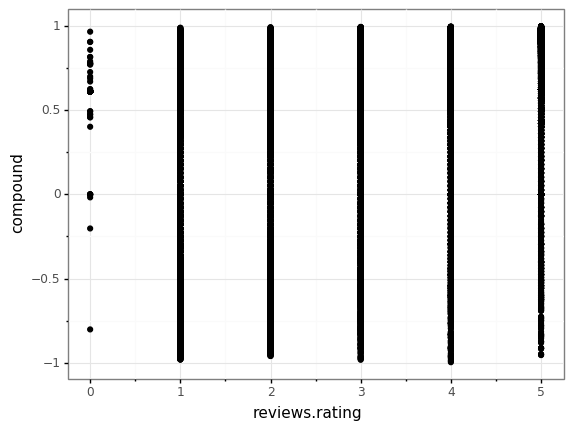

<ggplot: (-9223371910954902180)>

In [80]:
from plotnine import *
%matplotlib inline

ggplot(hotel_df, aes(x='reviews.rating', y='compound')) + geom_point()+theme_bw()

# test linear regression assumption

In [175]:
df = hotel_df[["reviews.rating", "compound"]]
df["reviews_rating"] = df.loc[:,["reviews.rating"]]
df

C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviews.rating,compound,reviews_rating
0,4.0,0.8299,4.0
1,5.0,0.9828,5.0
2,5.0,0.0000,5.0
3,5.0,0.9643,5.0
4,5.0,0.9643,5.0
...,...,...,...
35905,5.0,0.9813,5.0
35906,5.0,0.8271,5.0
35907,5.0,0.9888,5.0
35908,5.0,0.9759,5.0


In [176]:
import statsmodels.formula.api as smf
reg = smf.ols('reviews_rating ~ compound', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         reviews_rating   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Thu, 02 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:46:29   Log-Likelihood:                -54484.
No. Observations:               34599   AIC:                         1.090e+05
Df Residuals:                   34597   BIC:                         1.090e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1632      0.008    381.908      0.000       3.147       3.179
compound       1.3382      0.011    118.354      0.000       1.316       1.360
==============================================================================
Omnibus:                     3229.323   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17468.096
Skew:                           0.289   Prob(JB):                         0.00
Kurtosis:                       6.433   Cond. No.                         2.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# see correlation

In [ ]:
plotCorrelationMatrix(df1, 8)

# Linearity & Equal variance

From the below part, it seems random

In [ ]:
pred_val = reg.fittedvalues.copy()
true_val = df["reviews_rating"].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
scatter_plot= ax.scatter(residual, pred_val)

In [185]:
import statsmodels.stats.api as sms
import numpy as np
import statsmodels
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sms.linear_harvey_collier(reg)

Ttest_1sampResult(statistic=-1.8010068467411677, pvalue=0.07171050595373127)

In [186]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual, df[['compound']])
pval, f_pval

(nan, 1.009381780324e-312)

0.94166691392278

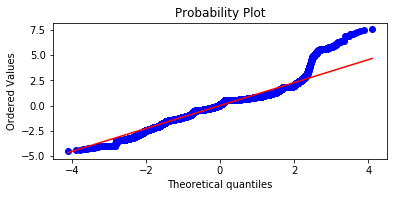

In [187]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

# Exploratory Analysis

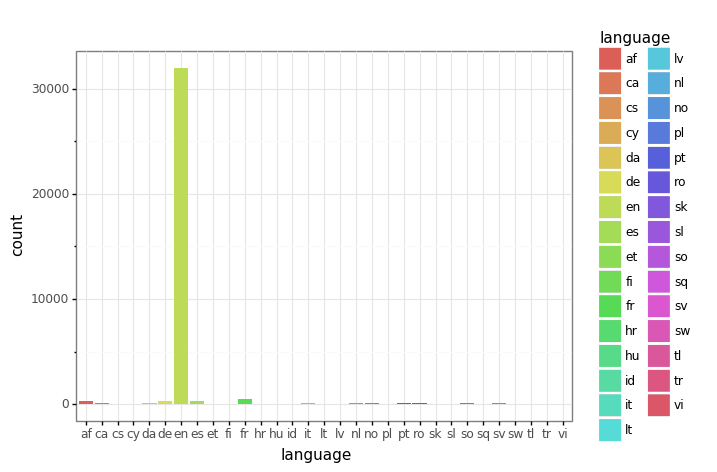

<ggplot: (-9223371845039541572)>

In [149]:
ggplot(hotel_df, aes(x = "language", fill = 'language')) + \
    geom_bar(stat = 'count')+ \
    theme_bw()

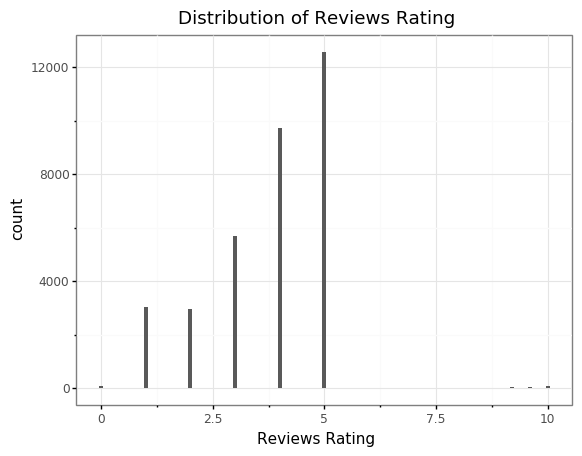

<ggplot: (-9223371845051980128)>

In [158]:
ggplot(hotel_df, aes(x = "reviews.rating")) + \
    geom_bar() + \
    theme_bw() +\
    xlab("Reviews Rating") + \
    ggtitle("Distribution of Reviews Rating")

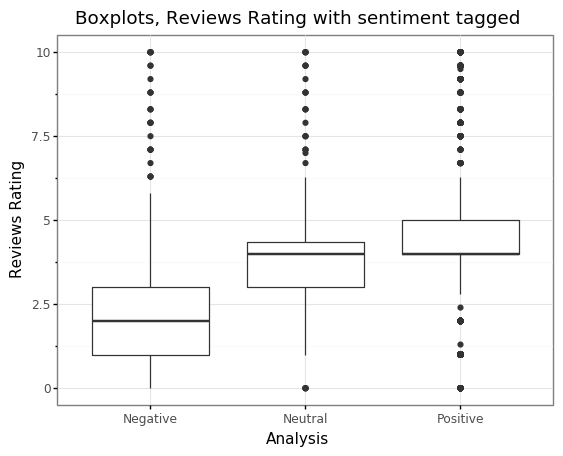

<ggplot: (-9223371845045044724)>

In [159]:
ggplot(hotel_df, aes(x = "Analysis", y = "reviews.rating")) + \
    geom_boxplot() + \
    theme_bw() + \
    ylab("Reviews Rating") + \
    ggtitle("Boxplots, Reviews Rating with sentiment tagged")

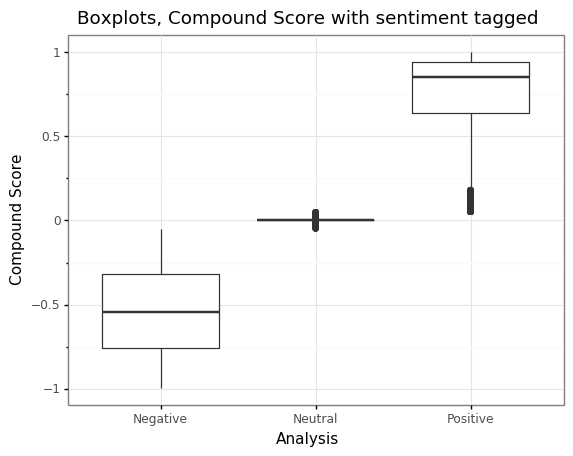

<ggplot: (-9223371845046088500)>

In [160]:
ggplot(hotel_df, aes(x = "Analysis", y = "compound")) + \
    geom_boxplot() + \
    theme_bw() + \
    ylab("Compound Score") + \
    ggtitle("Compound Score with sentiment tagged")

# vacation analysis

In [60]:
hotel_df = hotel_df[hotel_df["hotel_city"] != 'Curitiba']
statesList = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
cv = CountVectorizer(max_features=5000, ngram_range=(1,2),stop_words='english')
X = cv.fit_transform(hotel_df['cleaned_text'])
bag_of_words = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
# Join our bag of words back to our initial hotel data
full_df = hotel_df.join(bag_of_words)
# X is our words
X = bag_of_words

# Y is our hotel name (the outcome we care about)
Y_hotel = hotel_df['hotel_name']
LogR = LogisticRegression()

# Fit that random forest model to our data
LogR.fit(X,Y_hotel)



C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
# wrtie your onw dream hotel
# test_review from friend_1
test_review = ['''
    As long as the room is clean, I like to live in a hotel with breakfast and have a comfortable bed to enjoy sleeping. 
    
    ''']
# Convert your test review into a vector
X_test = vectorizer.transform(test_review).toarray()
#Match your review
prediction = LogR.predict(X_test)[0]
# Return the essential information about your match
hotel_df[hotel_df['hotel_name'] == prediction][['hotel_name', 'hotel_address', 
                                        'hotel_city', 'hotel_country']].head(1)

,hotel_name,hotel_address,hotel_city,hotel_country
30361,La Quinta Inn Auburn Worcester,446 Southbridge St,Auburn,US


In [104]:
# wrtie your onw dream hotel
# test_review from my friend_2.
test_review = ['''
I usually choose a hotel with relatively good comfort and hygienic conditions because I feel that I need to live in a comfortable place that makes me happy when I go out to play. 
This way you can relax during the journey and maintain a happy mood.
I would like to choose a hotel located nearby a subway with a reasonable price.
''']
# Convert your test review into a vector
X_test = vectorizer.transform(test_review).toarray()
#Match your review
prediction = LogR.predict(X_test)[0]
# Return the essential information about your match
hotel_df[hotel_df['hotel_name'] == prediction][['hotel_name', 'hotel_address', 
                                        'hotel_city', 'hotel_country']].head(1)

,hotel_name,hotel_address,hotel_city,hotel_country
19100,Country Inn and Suites By Carlson Galena,11334 Oldenburg Ln,Galena,US


In [116]:
# wrtie your onw dream hotel
# test_review from my friend_3.
test_review = ['''
I want to live at the very top floor and I can see all the views, I need a quiet environment
''']
# Convert your test review into a vector
X_test = vectorizer.transform(test_review).toarray()
#Match your review
prediction = LogR.predict(X_test)[0]
# Return the essential information about your match
hotel_df[hotel_df['hotel_name'] == prediction][['hotel_name', 'hotel_address', 
                                        'hotel_city', 'hotel_country']].head(1)

,hotel_name,hotel_address,hotel_city,hotel_country
27072,Hampton Inn Virginia Beach Oceanfront North,3107 Atlantic Ave,Virginia Beach,US


# Set Up Machine learning alothrims to predict hotel ratings

In [71]:
#split data first
run_ML = hotel_df.loc[:,["reviews.rating", "cleaned_text"]]
x_train, x_test, y_train, y_test = train_test_split(run_ML["cleaned_text"], run_ML["reviews.rating"], test_size=0.25, random_state = 42)

# Logistic

Logistic CV ngram(1,2) 

In [72]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = LogisticRegression()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("LogisticRegression:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression: 0.5216687853923495


Logistic tf-idf with ngram 1,2

In [73]:
tf = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = LogisticRegression()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("Logistic Regression:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression: 0.5335721715012135


# Linear support vector machine

CV with ngram

In [74]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = LinearSVC()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("LinearSVC:",accuracy_score(y_test, pred))

LinearSVC: 0.48341615624638856


C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


tf-idf with ngram

In [75]:
tf = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = LinearSVC()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("LinearSVC:",accuracy_score(y_test, pred))

LinearSVC: 0.5147347740667977


# Random Forest

CV with ngram

In [76]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = RandomForestClassifier(criterion="entropy")
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("RandomForestClassifier:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier: 0.45556454408875535


tf-idf with ngram

In [77]:
tf = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = RandomForestClassifier(criterion="entropy")
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("RandomForestClassifier:",accuracy_score(y_test, pred))

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier: 0.4437767248353172


# Bernoulli NB

CV with ngram

In [78]:
cv = CountVectorizer(ngram_range = (1,2), stop_words='english')
x_cv_train = cv.fit_transform(x_train)
x_cv_test = cv.transform(x_test)
classf = BernoulliNB()
classf.fit(x_cv_train, y_train)
pred = classf.predict(x_cv_test)
print("BernoulliNB:",accuracy_score(y_test, pred))

BernoulliNB: 0.4088755344967063


TF-IDF with ngram

In [79]:
tf = TfidfVectorizer(ngram_range=(1,1),stop_words='english')
x_tf_train = tf.fit_transform(x_train)
x_tf_test = tf.transform(x_test)
classf = BernoulliNB()
classf.fit(x_tf_train, y_train)
pred = classf.predict(x_tf_test)
print("BernoulliNB:",accuracy_score(y_test, pred))

BernoulliNB: 0.49659077776493704


# Language detect needs time to run

Compared whether there will be an improvement, after I performed language detect to exlcude non English words.

Start from sentiment analysis, run again. Go through each machine learning algorithms.

Also, start from hotel rating part, run again. Go through each machine learning algorithms.

I will compared accuracy of different machine learning algorithms in report.

In [61]:
hotel_df["language"] = hotel_df["reviews.text"].apply(detect)
hotel_df["language"]= hotel_df[hotel_df['language']=='en']

C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
